# 0. Preps

### 0.1 Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import brewer2mpl
import seaborn as sns
bmap = brewer2mpl.get_map('Set1', 'qualitative', 8)
colors = bmap.mpl_colors

### 0.2 Pre-set parameters for plotting

In [2]:
plt.rcParams.update({
    "font.weight": "normal",
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "lines.color": "k",
    "axes.titlesize": 18,
    "axes.titleweight": "normal",
    "axes.labelweight": "bold",
    "axes.labelsize": 18,
    "legend.fontsize": 14
})

### 0.3 Plotting function

In [3]:
def basic_plot(time,var,varM,label,xi,v_file,depth=False):
    '''
    This function plots a chosen variable as a function of time,
    and the variable's mean.
    _____________________________________________________________________
    
    time   ---> distance along x-axis
    var    ---> chosen variable 
    varM   ---> mean of chosen variable
    label  ---> specify label for legend
    xi     ---> location of cross-section
    v_file ---> specify if 2D or 3D velocity file
    _____________________________________________________________________
    '''
    #sns.set()                                                                            # set seaborn grid
    fig, ax  = plt.subplots(figsize=(6,4))                                                # plot fig with one subplot
    ax.plot  (time,var,label=label,color=colors[0],lw=4)                                  # plot the chosen variable as fct of time
    ax.hlines(varM,xmin=time[0],xmax=time[-1],label='mean '+label,color=colors[1],lw=4)   # plot the mean of the chosen variable
    ax.legend(loc=1)                                                                      # add legend and specify its location
    ax.grid()
    if depth==False:
        ax.set(title='Cross-section at i = '+str(xi/1000)+' km; '+v_file,xlabel='time [s]',ylabel='[m]')
    if depth==True:
        ax.set(title='Cross-section at i = '+str(xi/1000)+' km',xlabel='time [s]',ylabel='[m]')

### 0.4 Load file with resolved tidal data

In [4]:
path_file = '/home/henell/WORK/tools/GETM/setups/warner/warner.3d_upd2.nc'    # location of file
id_file   = netCDF4.Dataset(path_file, 'r')                                   # read file

### 0.5 Location of cross-section

In [5]:
i = 45 ; j = 0

In [6]:
time  = id_file.variables['time'][1:]         # [s]; exclude initial tidal snapshot (avoid double-counting during tidal averaging)
dx    = id_file.variables['dx'][:]            # grid spacing (x) [m]
dy    = id_file.variables['dy'][:]            # grid spacing (y) [m]

# 1. 2D Caluclations: analyze depth-averaged data

## 1.1 Analyze water depth

In [7]:
xcl = id_file.variables['xc'][i]                  # xc [m] @ center of the cell (LHS) 
xcr = id_file.variables['xc'][i+1]                # xc [m] @ center of the cell (RHS)
xi  = 0.5 * ( xcl + xcr )                         # average to U-point interface between center cells
print( '\n Analyze cross-section ',
      xi/1000, ' km upstream of open boundary.' )


 Analyze cross-section  22.5  km upstream of open boundary.


In [8]:
bathyl = id_file.variables['bathymetry'][j,i]    # bathymetry (H) [m] @ center of the cell (LHS) 
bathyr = id_file.variables['bathymetry'][j,i+1]  # bathymetry (H) [m] @ center of the cell (RHS) 
bathyi = 0.5 * ( bathyl + bathyr )               # average to U-point interface between center cells

In [9]:
elevl = id_file.variables['elev'][:,j,i]                             # elevation (eta) [m] @ center of the cell (LHS) 
elevr = id_file.variables['elev'][:,j,i+1]                           # elevation (eta) [m] @ center of the cell (RHS) 
elevi = 0.25 * ( elevl[:-1] + elevl[1:] + elevr[:-1] + elevr[1:] )   # average in space and time

In [10]:
Di      = bathyi + elevi     # time-varying water depth
Di_mean = Di.mean()          # mean water depth

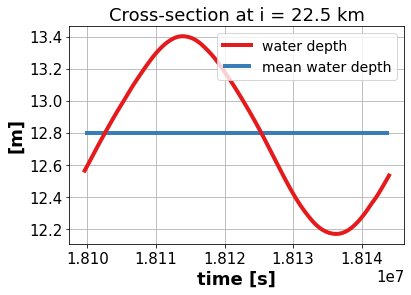

In [11]:
basic_plot(time,Di,Di_mean,'water depth',xi,'u2D',depth=True)

### 1.2 Analyze depth-averaged velocity

In [12]:
u2d      = id_file.variables[ 'u'][1:,j,i]                    # time-varying depth-averaged velocity [m/s]
u2d_mean = u2d.mean()                                         # mean depth-averaged velocity [m/s]
print( 'Mean depth-averaged velocity is <u2d> ='+str(u2d_mean)+' ms-1')

Mean depth-averaged velocity is <u2d> =-0.01744459 ms-1


In [13]:
#basic_plot(time,u2d,u2d_mean,'depth-averaged velocity',xi,'u2D')

### 1.3 Analyze depth-integrated transport

In [14]:
Di_mean_u2d_mean = Di_mean * u2d_mean                                            # mean depth-integrated transport from 2D u-field
print( 'First guess for mean depth-integrated transport is dy*<D>*<u2d> = '+
      str(dy*Di_mean_u2d_mean)+' m3s-1')

First guess for mean depth-integrated transport is dy*<D>*<u2d> = -111.60142719745636 m3s-1


### Calculating $dy  <D \cdot u2d >$

In [15]:
Du2d      = Di * u2d                                                             # time-varying depth-integrated transport from 2D u-field
Du2d_mean = Du2d.mean()                                                          # mean depth-integrated transport from 2D u-field
print( 'Mean depth-integrated transport is dy * < D*u2d > ='+
      str(dy*Du2d_mean)+' m3s-1')

Mean depth-integrated transport is dy * < D*u2d > =-49.96088519692421 m3s-1


In [16]:
#basic_plot(time,Du2d,Du2d_mean,'depth-integrated transport',xi,'u2D')

### 1.4 Define mean transport velocity

In [17]:
u2d_twa = Du2d_mean / Di_mean
print( 'Mean depth-integrated transport velocity is <D*u2d>/<D> ='+str(u2d_twa)+' ms-1')
print( 'Mean depth-averaged velocity is                   <u2d> ='+str(u2d_mean)+' ms-1')

Mean depth-integrated transport velocity is <D*u2d>/<D> =-0.0078094625 ms-1
Mean depth-averaged velocity is                   <u2d> =-0.01744459 ms-1


### 1.5 2D guess for Q$_{in}$ and Q$_{out}$

In [18]:
#########################################################################################
# We are not interested in this way of averaging over the positive and negative transport 
# since what we want to look at is the positive and negative transport averaged over the 
# whole time period.
#########################################################################################

#Du2d_in  =  np.fmax( 0 , Du2d )                               # only consider positive transports
#Du2d_out = -np.fmin( Du2d , 0 )                               # only consider negative transports
#Qin_2d   = Du2d_in.mean() * dy
#Qout_2d  = Du2d_out.mean() * dy
#print( 'First guess for Qin is   dy*<(D*u2d)^+> =', Qin_2d )
#print( 'First guess for Qout is -dy*<(D*u2d)^-> =', Qout_2d )

In [19]:
print( '2D guess for Qin  from tidally-averaged data is  dy*<D*u2d>^+ ='+str(np.fmax( 0 , Du2d_mean ) * dy)+' m3s-1')        # only consider positive transports
print( '2D guess for Qout from tidally-averaged data is -dy*<D*u2d>^- ='+str(-np.fmin( Du2d_mean , 0 ) * dy)+' m3s-1')       # only consider negative transports

2D guess for Qin  from tidally-averaged data is  dy*<D*u2d>^+ =0.0 m3s-1
2D guess for Qout from tidally-averaged data is -dy*<D*u2d>^- =49.96088519692421 m3s-1


### 1.6 Check volume balance

In [20]:
t0     = id_file.variables['time'][ 0]
t1     = id_file.variables['time'][-1]
bathy1 = id_file.variables['bathymetry'][j,i+1:]
elev0  = id_file.variables['elev'][ 0,j,i+1:]
elev1  = id_file.variables['elev'][-1,j,i+1:]
D0     = bathy1 + elev0
D1     = bathy1 + elev1
V0     = D0.sum() * dx * dy
V1     = D1.sum() * dx * dy
print(' dV/dt ='+str(( V1 - V0 ) / ( t1 - t0 ))+' m3s-1')
print(' Qin - Qout + Qr ='+str(np.fmax( 0 , Du2d_mean ) * dy - (-np.fmin( Du2d_mean , 0 ) * dy) + 50)+' m3s-1' )  #### averaging no. 1
#print(' Qin - Qout + Qr =', Qin_2d - Qout_2d + 50 )                                                              #### averaging no. 2

 dV/dt =0.039201612318200726 m3s-1
 Qin - Qout + Qr =0.039114803075790405 m3s-1


==> Slightly non-periodic state dV/dt<>0 (could be avoided by averaging over more tidal cycles) !!!  
==> Volume balance is ok (single precision errors can be avoided with `-D_NCDF_SAVE_DOUBLE_`) !!!

# 2. 3D Calculations: analyze depth-resolved data

### 2.1 Calculate layer heights and vertical positions

In [21]:
if 'h' in id_file.variables.keys():                                 # if h is a variable in the opened file
    hl = id_file.variables['h'][:,1:,j,i]
    hr = id_file.variables['h'][:,1:,j,i+1]
    hi = 0.25 * ( hl[:-1,:] + hl[1:,:] + hr[:-1,:] + hr[1:,:] )     # average in space and time
elif 'sigma' in id_file.variables.keys():                           # if sigma is a variable in the opened file
    sigma = id_file.variables['sigma'][:]
    hi    = np.outer( Di , np.diff(sigma) )
else:                                                               # if neither h nor sigma is a variable in the opened file
    kmax = u3d.shape[1]                                             # max depth index
    hi   = np.outer( Di , np.ones(kmax) / kmax )                    # assume equidistant sigma coordinates
kmax = hi.shape[1]

In [22]:
zwi = np.insert( hi, 0, -bathyi, axis=1 ).cumsum(axis=1)            # interface position
zci = 0.5 * ( zwi[:,:-1] + zwi[:,1:] )                              # center position

### 2.2 Analyze depth-resolved velocity

In [23]:
u3d = id_file.variables['uu'][1:,1:,j,i]

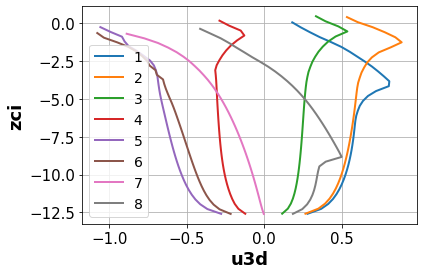

In [24]:
nmax = u3d.shape[0]                          # max time index
nprofs = 8 # should be multiple of 4         # ?
for n in range(nmax):
    if not (n+1)%(nmax//nprofs): plt.plot(u3d[n,:],zci[n,:],lw=2,label=str((n+1)//(nmax//nprofs)))
plt.legend()
plt.grid()
plt.xlabel('u3d')
plt.ylabel('zci')
plt.show()

### 2.3 Mean depth-resolved velocity

In [25]:
u3d_mean = u3d.mean(axis=0)      # averaging over time

### 2.4 Mean depth-resolved transport velocity

In [26]:
hu3d      = hi * u3d               # product of hi with u3d, still time-varying and depth-resolving     
hu3d_mean = hu3d.mean(axis=0)      # average of product h with u3d along time: <h*u3d>
hi_mean   = hi.mean(axis=0)        # average of layer thickness hi in time 
u3d_twa   = hu3d_mean / hi_mean    # weighted average velocity = <h*u3d> / <h>

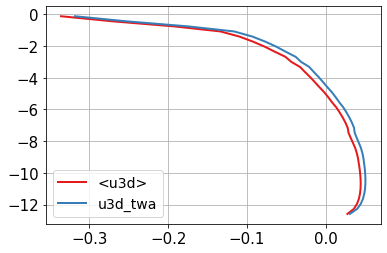

dy*sum(<h>*<u3d>)                              = -111.6014640603555 m3s-1
dy*sum(<h>*<u3d_twa>)                          = -49.960799128203135 m3s-1
Mean depth-integrated transport was dy*<D*u2d> = -49.96088519692421 m3s-1


In [27]:
zci_mean = zci.mean(axis=0)
plt.plot(u3d_mean,zci_mean,label='<u3d>',  color=colors[0],lw=2)
plt.plot(u3d_twa, zci_mean,label='u3d_twa',color=colors[1],lw=2)
plt.legend()
plt.grid()
plt.show()
print( 'dy*sum(<h>*<u3d>)                              = '+str(dy * np.sum( hi_mean * u3d_mean ))+' m3s-1')
print( 'dy*sum(<h>*<u3d_twa>)                          = '+str(dy * np.sum( hi_mean * u3d_twa ))+' m3s-1')
print( 'Mean depth-integrated transport was dy*<D*u2d> = '+str(dy*Du2d_mean)+' m3s-1')

==> `u3d_twa = <h*u3d>/<h>` is the mean depth-resolved velocity consistent with the volume transport !!!

### 2.5 3D guess for Q$_{in}$ and Q$_{out}$

In [28]:
#########################################################################################
# We are not interested in this way of averaging over the positive and negative transport 
# since what we want to look at is the positive and negative transport averaged over the 
# whole time period.
#########################################################################################

#hu3d_in  =  np.fmax( 0 , hu3d )                                        # only consider positive transports
#hu3d_out = -np.fmin( hu3d , 0 )                                        # only consider negative transports
#Qin_3d   = hu3d_in. sum(axis=1).mean() * dy
#Qout_3d  = hu3d_out.sum(axis=1).mean() * dy
#print( '3D guess for Qin is   dy*<sum( (h*u3d)^+ )> =', Qin_3d )
#print( '3D guess for Qout is -dy*<sum( (h*u3d)^- )> =', Qout_3d )
#print( 'Qin - Qout =', Qin_3d - Qout_3d)
#print( '2D guess for Qin was         dy*<(D*u2d)^+> =', Qin_2d )
#print( '2D guess for Qout was       -dy*<(D*u2d)^-> =', Qout_2d )

In [29]:
print( '2D guess for Qin  from tidally-averaged data is         dy*<D*u2d>^+ = '+str(np.fmax( 0 , Du2d_mean ) * dy)+' m3s-1')            # only consider positive transports
print( '2D guess for Qout from tidally-averaged data is        -dy*<D*u2d>^- = '+str(-np.fmin( Du2d_mean , 0 ) * dy)+' m3s-1')           # only consider negative transports
print( '3D guess for Qin  from tidally-averaged data is  dy*sum( <h*u3d>^+ ) = '+str(np.sum( np.fmax( 0 , hu3d_mean ) ) * dy)+' m3s-1')  # only consider positive transports
print( '3D guess for Qout from tidally-averaged data is -dy*sum( <h*u3d>^- ) = '+str(-np.sum( np.fmin( hu3d_mean , 0 ) ) * dy)+' m3s-1') # only consider negative transports

2D guess for Qin  from tidally-averaged data is         dy*<D*u2d>^+ = 0.0 m3s-1
2D guess for Qout from tidally-averaged data is        -dy*<D*u2d>^- = 49.96088519692421 m3s-1
3D guess for Qin  from tidally-averaged data is  dy*sum( <h*u3d>^+ ) = 152.3470942983925 m3s-1
3D guess for Qout from tidally-averaged data is -dy*sum( <h*u3d>^- ) = 202.3078934265956 m3s-1


We are interested in the Q$_{in}$ and Q$_{out}$ values where we first average and then choose the positive values, i.e. $< x >^+$ and not $< x^+>$. This gives us the average inflow and outflow over the whole time period.

# 3 Binning into salt classes

In [30]:
salt = id_file.variables['salt'][:-1,1:,j,i]      # salinity [gkg-1]

In [31]:
nbins = 10                                        # number of bins
Smin  = salt.min() - 1e-10                        # minimum salinity
Smax  = salt.max()                                # maximum salinity
Si    = np.linspace( Smin , Smax , nbins+1 )      # interface position
S_s   = 0.5 * ( Si[:-1] + Si[1:] )                # center position
print(Si)

[11.62690258 13.01780272 14.40870285 15.79960299 17.19050312 18.58140326
 19.97230339 21.36320353 22.75410366 24.1450038  25.53590393]


In [32]:
h_s   = np.zeros( (nmax,nbins+1) )
hu_s  = np.zeros( (nmax,nbins+1) )
hus_s = np.zeros( (nmax,nbins+1) )
for n in range(nmax):                                                                   # loop over range of max time index
    for k in range(kmax):                                                               # loop over range of max depth index
        bin = max( 0 , int( np.ceil( (salt[n,k]-Si[0])/(Si[nbins]-Si[0])*nbins ) ) )    
        if bin > nbins: continue
        h_s  [n,bin] = h_s  [n,bin] + hi[n,k]                                           # h binned into salt classes
        hu_s [n,bin] = hu_s [n,bin] + hi[n,k]*u3d[n,k]                                  # h*u binned into salt classes
        hus_s[n,bin] = hus_s[n,bin] + hi[n,k]*u3d[n,k]*salt[n,k]                        # h*u*s binned into salt classes

### 3.1 Calculating the weighted average velocity

In [33]:
h_s_mean   = h_s.  mean(axis=0)                 # average over time: <h_s>
hu_s_mean  = hu_s. mean(axis=0)                 #    -  same  -    : <hu_s>
hus_s_mean = hus_s.mean(axis=0)                 #    -  same  -    : <hus_s>  

In [34]:
u_s_twa    = np.zeros_like(h_s_mean)            # return an array of zeros with the same shape and type as h_s_mean
np.divide(hu_s_mean,h_s_mean,                   # return a true division of the inputs hu_s_mean and h_s_mean
          out=u_s_twa,where=(h_s_mean > 0));    # thus returns the weighted average velocity binned into salt classes: u_s_twa

In [35]:
print('\n The weighted average velocity binned into salt classes u_s_twa = ');print('\n',u_s_twa)


 The weighted average velocity binned into salt classes u_s_twa = 

 [ 0.         -0.36865879 -0.33506702 -0.26783413 -0.10192635 -0.17421776
 -0.03589898 -0.01951669  0.00484852  0.02798799  0.01528308]



 dy*sum(hu_s_mean) = -49.96079912820323


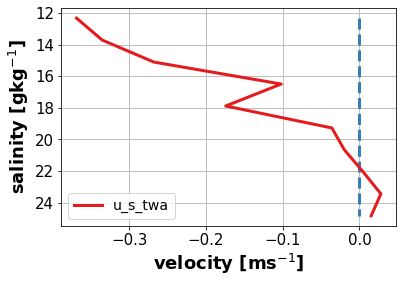

In [36]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(u_s_twa[1:],S_s,lw=3,color=colors[0],label='u_s_twa')
ax.invert_yaxis()
ax.vlines(0,ymin=S_s[0],ymax=S_s[-1],lw=3,ls='--',color=colors[1])
ax.grid()
ax.set(xlabel='velocity [ms$^{-1}$]',ylabel='salinity [gkg$^{-1}$]')
ax.legend(loc=3)
print('\n dy*sum(hu_s_mean) =' , dy*hu_s_mean.sum())

### 3.2 Calculating the salt fluxes

(((-----------------------

In [37]:
Q_s_twa = np.zeros_like(hus_s_mean)
np.divide(hus_s_mean,h_s_mean,out=Q_s_twa);
Q_s_twa[np.isnan(Q_s_twa)] = 0

<ipython-input-37-6329909a6c91>:2: RuntimeWarning: invalid value encountered in true_divide
  np.divide(hus_s_mean,h_s_mean,out=Q_s_twa);


In [38]:
Q_s_twa_out = - Q_s_twa.min() * dy.data
Q_s_twa_in  = Q_s_twa[-1]*dy.data + (- Q_s_twa.min() * dy.data)

In [39]:
print('Q_s_twa_in  = '+str(Q_s_twa_in)+' m3s-1gkg-1')
print('Q_s_twa_out = '+str(Q_s_twa_out)+' m3s-1gkg-1')

Q_s_twa_in  = 2536.7657262913344 m3s-1gkg-1
Q_s_twa_out = 2350.9958143920894 m3s-1gkg-1


-----------------------)))

In [40]:
M_salt_le_s = hus_s_mean.cumsum()
Fout   = -M_salt_le_s.min() * dy
Fin    = M_salt_le_s[-1]*dy + Fout
print( 'isohaline guess for Fin  from tidally-averaged data is = '+str(Fin)+' m3s-1gkg-1')
print( 'isohaline guess for Fout from tidally-averaged data is = '+str(Fout)+' m3s-1gkg-1')

isohaline guess for Fin  from tidally-averaged data is = 2003.0631678092116 m3s-1gkg-1
isohaline guess for Fout from tidally-averaged data is = 2092.9655902932204 m3s-1gkg-1


In [41]:
#fig, ax = plt.subplots(figsize=(6,4))
#ax.plot(Q_s_twa_in[1:] ,S_s,lw=3,color=colors[0],label='Q_s_twa_in')
#ax.plot(Q_s_twa_out[1:],S_s,lw=3,color=colors[1],label='Q_s_twa_out')
#ax.invert_yaxis()
#ax.grid()
#ax.set(xlabel='salt flux',ylabel='salinity [gkg$^{-1}$]')
#ax.legend(loc=1)
#print('\n dy*sum(hus_s_mean) =' , dy*hus_s_mean.sum())

### 3.3 Calculate Q$_{in}$ and Q$_{out}$

### 3.3.1 Sign method

##### (MacCready 2011 eq. (3.3) and Lorenz et al. 2019 eq. (5))

In [42]:
print( 'isohaline guess for Qin  from tidally-averaged data is  dy*sum( <hu_s>^+ ) = '+str( np.sum( np.fmax( 0 , hu_s_mean ) ) * dy)+' m3s-1')
print( 'isohaline guess for Qout from tidally-averaged data is -dy*sum( <hu_s>^- ) = '+str(-np.sum( np.fmin( hu_s_mean , 0 ) ) * dy)+' m3s-1')

isohaline guess for Qin  from tidally-averaged data is  dy*sum( <hu_s>^+ ) = 83.6804593231267 m3s-1
isohaline guess for Qout from tidally-averaged data is -dy*sum( <hu_s>^- ) = 133.64125845132992 m3s-1


In [43]:
print('This corresponds to a difference of: '+str(-np.sum( np.fmin( hu_s_mean , 0 ) ) * dy - np.sum( np.fmax( 0 , hu_s_mean ) ) * dy)+' m3s-1')

This corresponds to a difference of: 49.96079912820322 m3s-1


The former two 3D estimates correspond to:

In [44]:
print('3D guess for Qin  from tidally-averaged data is  dy*sum( <h*u3d>^+ ) = '+str(np.sum( np.fmax( 0 , hu3d_mean ) ) * dy)+' m3s-1')  # only consider positive transports
print('3D guess for Qout from tidally-averaged data is -dy*sum( <h*u3d>^- ) = '+str(-np.sum( np.fmin( hu3d_mean , 0 ) ) * dy)+' m3s-1') # only consider negative transports

3D guess for Qin  from tidally-averaged data is  dy*sum( <h*u3d>^+ ) = 152.3470942983925 m3s-1
3D guess for Qout from tidally-averaged data is -dy*sum( <h*u3d>^- ) = 202.3078934265956 m3s-1


In [45]:
print('... which corresponds to a difference of: '+str(-np.sum( np.fmin( hu3d_mean , 0 ) ) * dy - np.sum( np.fmax( 0 , hu3d_mean ) ) * dy)+' m3s-1')

... which corresponds to a difference of: 49.96079912820309 m3s-1


### 3.3.2 Dividing salinity or minmax method

##### (MacCready 2018 appendix and Lorenz et al. 2019 eq. (7))

In [46]:
M_le_s = hu_s_mean.cumsum()
Si_idx = M_le_s.argmin()
Qout   = -M_le_s.min() * dy
Qin    = M_le_s[-1]*dy + Qout
print( 'isohaline guess for Qin  from tidally-averaged data is '+str(Qin)+' m3s-1')
print( 'isohaline guess for Qout from tidally-averaged data is '+str(Qout)+' m3s-1')

isohaline guess for Qin  from tidally-averaged data is 83.68045932312668 m3s-1
isohaline guess for Qout from tidally-averaged data is 133.64125845132995 m3s-1


In [47]:
print('... which corresponds to a difference of: '+str(Qout - Qin)+' m3s-1')

... which corresponds to a difference of: 49.96079912820326 m3s-1


### Summary:

In [48]:
print('\n Sign method: ')
print(' Binning into salt classes: Qout - Qin = '+str(-np.sum( np.fmin( hu_s_mean , 0 ) ) * dy - np.sum( np.fmax( 0 , hu_s_mean ) ) * dy)+' m3s-1')
print(' 3D estimates:              Qout - Qin = '+str(-np.sum( np.fmin( hu3d_mean , 0 ) ) * dy - np.sum( np.fmax( 0 , hu3d_mean ) ) * dy)+' m3s-1')
print('\n Minmax method: ')
print(' Binning into salt classes: Qout - Qin = '+str(Qout - Qin)+' m3s-1')


 Sign method: 
 Binning into salt classes: Qout - Qin = 49.96079912820322 m3s-1
 3D estimates:              Qout - Qin = 49.96079912820309 m3s-1

 Minmax method: 
 Binning into salt classes: Qout - Qin = 49.96079912820326 m3s-1


### 3.4 Calculating $s_{in}$ and $s_{out}$

In [49]:
### inflowing salt  =  (inflowing salt flux) / (inflowing volume flux)
### outflowing salt = (outflowing salt flux) / (outflowing volume flux)
### Calculation with the volume fluxes calculated using the dividing salinity/minmax method 
### since this method converges even for a higher number of salt classes.

S_in  = Fin  / Qin
S_out = Fout / Qout
print('\n S_in  = '+str(S_in)+' gkg-1')
print('\n S_out = '+str(S_out)+' gkg-1')


 S_in  = 23.93704795613648 gkg-1

 S_out = 15.661073642579067 gkg-1
